In [1]:
# Data stuff
from dask_ml import preprocessing
le = preprocessing.LabelEncoder()
import pandas as pd
import dask.dataframe as dd

# Visual stuff
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# ML stuff
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# VIP STUFF!
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.  Launch dashboard

In [2]:
samples_transformed = dd.read_csv('../data_gen/samples_transformed/*.part')
# Drop all underage patients
samples_transformed = samples_transformed[samples_transformed.age_at_admission>=18].compute()

## Show some stats about the dataframe and missing values

In [3]:
print('Stats')
display(samples_transformed.describe())
print('Number of patients: ' ,samples_transformed.shape[0])
print('missing value counts for each column')
display(samples_transformed.isna().sum().sort_values(ascending=False))

Stats


,ethnicity_AMERICAN INDIAN/ALASKA NATIVE,ethnicity_ASIAN,ethnicity_BLACK/AFRICAN AMERICAN,ethnicity_HISPANIC/LATINO,ethnicity_WHITE,insurance_Medicaid,insurance_Medicare,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SINGLE,marital_status_WIDOWED,age_at_admission,seq_num,times_prev_admitted,length_of_stay(days),BMI,Glucose,Potassium,Sodium,Chloride,Bicarbonate,Anion Gap,Creatinine,Urea Nitrogen,Magnesium,Hematocrit,Hemoglobin,Platelet Count,Phosphate,"Calcium, Total",White Blood Cells,MCHC,MCH,MCV,Red Blood Cells,RDW,pH,PTT,PT,INR(PT),Specimen Type,L,H,I,RDW-SD,pO2,Calculated Total CO2,Base Excess,pCO2,"Bilirubin, Total",Alanine Aminotransferase (ALT),hospital_expire_flag,gender,language_english
count,19886.000000,19886.000000,19886.000000,19886.000000,19886.000000,19886.000000,19886.000000,19886.000000,19886.000000,19886.000000,19886.000000,19886.000000,19886.000000,19886.000000,19886.000000,4653.000000,17461.000000,19214.000000,19148.000000,19195.000000,19206.000000,19221.000000,19240.000000,19235.000000,18774.000000,19212.000000,19231.000000,19203.000000,18626.000000,18647.000000,19220.000000,8701.000000,19225.000000,19228.000000,19229.000000,19219.000000,13626.000000,14446.000000,14759.000000,0.0,0.0,13013.000000,19214.000000,6380.000000,8694.000000,8829.000000,8830.000000,8832.000000,8830.000000,12179.000000,0.0,19886.000000,19886.000000,19886.000000
mean,0.002464,0.035201,0.141406,0.040632,0.686563,0.073871,0.504626,0.075078,0.423967,0.310671,0.151162,67.574877,2.673439,3.837423,9.453787,28.358896,137.381421,4.987114,135.864320,100.842563,24.562991,14.812237,4.242391,35.486509,1.949739,32.906022,10.722323,227.456804,3.569897,8.530874,11.337827,32.090668,29.760837,91.495527,3.623774,15.362672,6.708432,36.606763,27.199329,NaN,NaN,183.408515,32.484974,9.135997,51.372510,107.506966,26.411325,-0.194407,44.633069,1.230980,NaN,0.100925,0.540129,0.882581
std,0.049579,0.184291,0.348449,0.197440,0.463902,0.261568,0.499991,0.263524,0.494198,0.462780,0.358215,16.579870,2.100341,6.890170,13.385924,8.133900,83.500333,6.245353,15.259044,10.561081,4.771686,3.804561,19.130967,82.603209,0.427501,6.379839,2.155037,125.078136,1.957610,0.820736,11.107633,1.618664,2.997879,7.923863,0.750188,2.396558,0.839991,19.788429,19.695495,NaN,NaN,730.600875,6.312933,27.828816,8.991385,86.308101,6.677175,5.673876,14.741781,3.169342,NaN,0.301237,0.498400,0.321927
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.154689,1.000000,0.000000,-1.000000,11.386593,0.000000,1.000000,7.000000,10.000000,3.000000,1.000000,0.000000,2.000000,0.300000,2.000000,3.100000,5.000000,0.200000,1.000000,0.100000,24.900000,14.600000,58.000000,0.900000,10.800000,5.000000,16.900000,8.600000,NaN,NaN,1.000000,0.400000,1.000000,31.100000,14.000000,0.000000,-34.000000,9.000000,0.000000,NaN,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,57.142368,1.000000,0.000000,3.000000,23.100907,96.000000,3.700000,135.000000,98.000000,22.000000,12.000000,0.700000,13.000000,1.700000,28.500000,9.200000,148.000000,2.800000,8.100000,6.675000,31.100000,28.200000,87.000000,3.110000,13.600000,6.000000,27.800000,13.800000,NaN,NaN,18.000000,29.600000,2.000000,45.200000,52.000000,22.000000,-3.000000,35.000000,0.300000,NaN,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,69.000684,2.000000,1.000000,6.000000,26.729927,115.000000,4.100000,138.000000,102.000000,25.000000,14.000000,1.000000,20.000000,1.900000,33.000000,10.700000,208.000000,3.400000,8.600000,9.600000,32.200000,29.900000,91.000000,3.620000,14.800000,7.200000,31.200000,25.400000,NaN,NaN,42.000000,32.850000,3.000000,49.300000,78.000000,26.000000,0.000000,42.000000,0.500000,NaN,0.000000,1.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,80.621492,3.000

Number of patients:  19886
missing value counts for each column


INR(PT)                                    19886
Alanine Aminotransferase (ALT)             19886
Specimen Type                              19886
BMI                                        15233
I                                          13506
RDW-SD                                     11192
MCHC                                       11185
pO2                                        11057
pCO2                                       11056
Calculated Total CO2                       11056
Base Excess                                11054
Bilirubin, Total                            7707
L                                           6873
pH                                          6260
PTT                                         5440
PT                                          5127
Glucose                                     2425
Phosphate                                   1260
Calcium, Total                              1239
Magnesium                                   1112
Sodium              

## Drop features if too many are missing

In [4]:
# Drop too many missing values(1/3 of total might be ok) for features, BMI is an exception
limit_missing = samples_transformed.shape[0] / 3
labels_to_drop = []
for feature in samples_transformed.columns.values.tolist():
    if (samples_transformed[feature].isna().sum() > limit_missing) & (feature!='BMI'):
        labels_to_drop = labels_to_drop + [feature]
samples_transformed = samples_transformed.drop(labels=labels_to_drop, axis='columns')

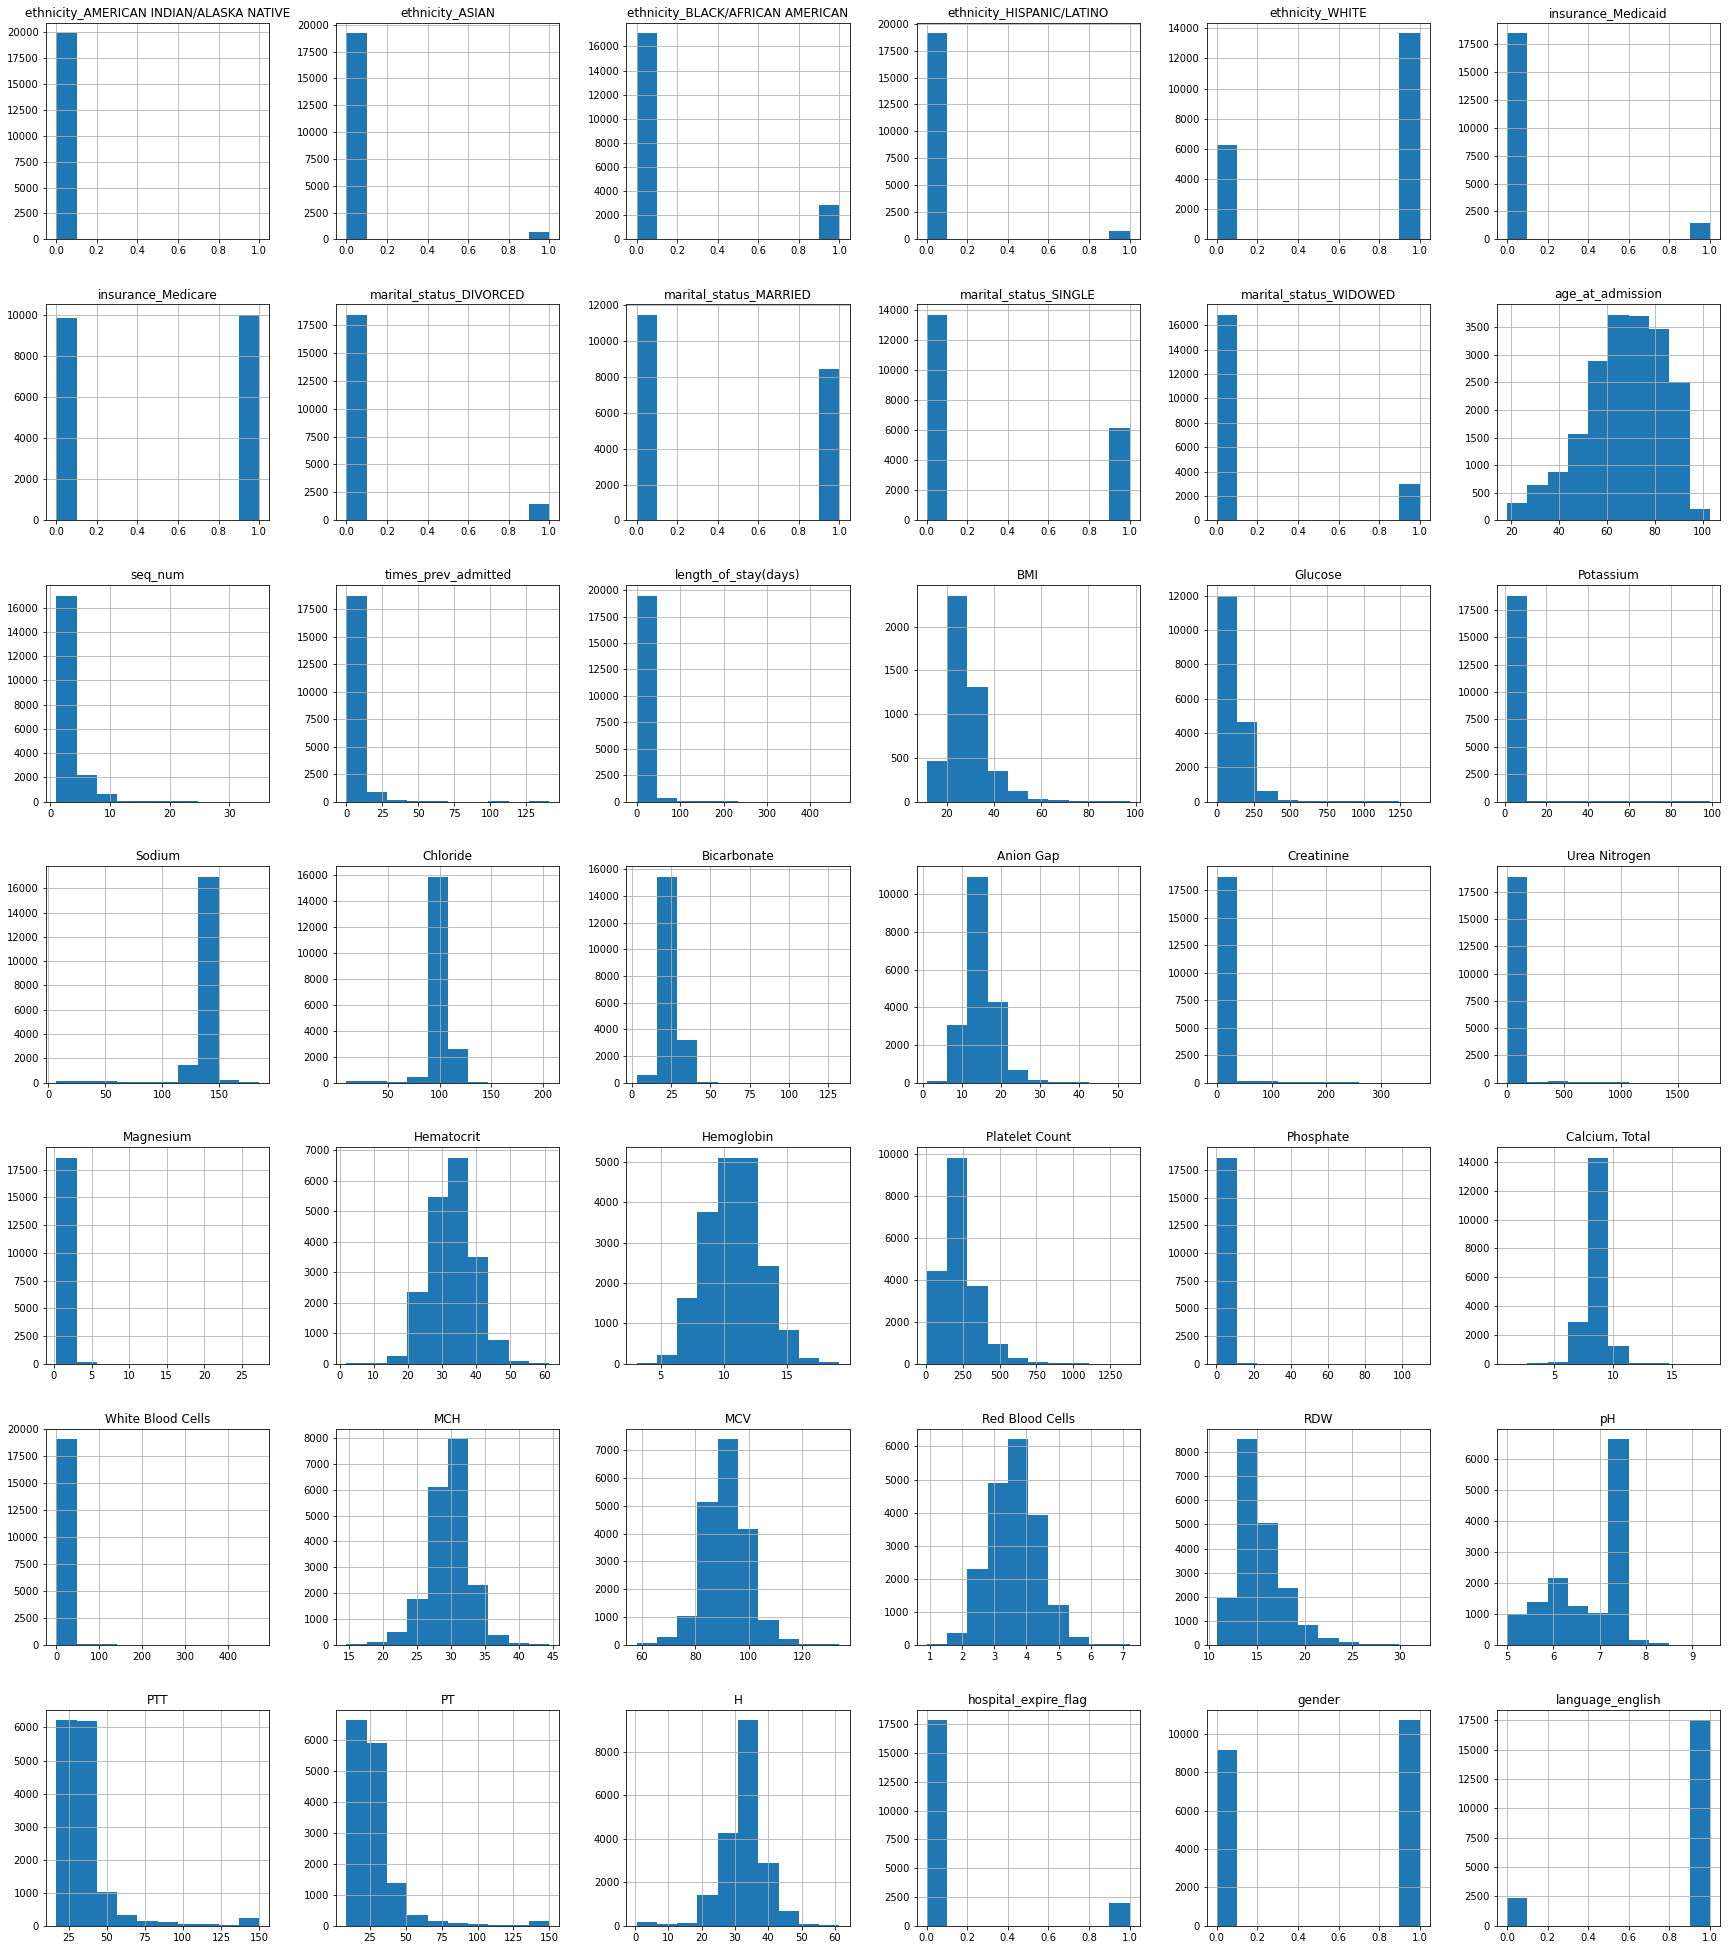

In [5]:
# Show histogram distributions
samples_transformed.hist(sharey=False,figsize=(30,35))
print('')

In [6]:
# Numbers of admissions ending in death
n_died =  samples_transformed[samples_transformed.hospital_expire_flag==1].shape[0]

# No interpolation

In [7]:
# Generate new (non-shallow) copy
df = samples_transformed.copy(deep=True)

# Entire dataset
dd.from_pandas(df, npartitions=6).to_csv('../data_gen/dataset_missing_entire', index=False)

# Undersample
df = df[df.hospital_expire_flag==1].append(df[df.hospital_expire_flag==0].sample(n_died))
dd.from_pandas(df, npartitions=6).to_csv('../data_gen/dataset_missing_undersample', index=False)
print('done')

done


## Mean values

In [8]:
# Generate new (non-shallow) copy
df = samples_transformed.copy(deep=True)

# Replace missing values(nan values) with mean of column
for column in enumerate(df.columns.values.tolist()):
    df[column[1]].fillna(inplace=True, value=df[column[1]].mean())
    
# Entire dataset
dd.from_pandas(df, npartitions=6).to_csv('../data_gen/dataset_mean_entire', index=False)

# Undersample
df = df[df.hospital_expire_flag==1].append(df[df.hospital_expire_flag==0].sample(n_died))
dd.from_pandas(df, npartitions=6).to_csv('../data_gen/dataset_mean_undersample', index=False)
print('done')

done


## KNN

In [9]:
# Function to impute missing values using KNN
def impute_missing(df):
    target_temp = df.hospital_expire_flag.values.tolist()
    # Don't include target variable in KNN, it would introduce bias
    df = df.drop(columns=['hospital_expire_flag'])
    df_cols = df.columns
    # scaler
    scaler = StandardScaler()
    # imputer
    imputer = KNNImputer(n_neighbors=5)

    # re-scale dataframe
    df = pd.DataFrame(scaler.fit_transform(df), columns =df_cols)
    # impute missing values
    df = pd.DataFrame(imputer.fit_transform(df),columns = df_cols)
    # re-scale to original values
    df = pd.DataFrame(scaler.inverse_transform(df), columns = df_cols)
    
    # Re-add target variable
    df['hospital_expire_flag'] = target_temp
    
    return df

In [10]:
# New copy and impute
df = impute_missing(samples_transformed.copy(deep=True))

# Entire dataset
dd.from_pandas(df, npartitions=6).to_csv('../data_gen/dataset_KNN_entire', index=False)

# Undersample
df = df[df.hospital_expire_flag==1].append(df[df.hospital_expire_flag==0].sample(n_died))
dd.from_pandas(df, npartitions=6).to_csv('../data_gen/dataset_KNN_undersample', index=False)
print('done')

done
